# Introduction
Fake news detection is crucial in today's information-driven society. This project aims to develop a machine learning model to classify news articles as fake or real.

## System Overview
```python
+-------------------+     +-------------------+     +--------------------+
|                   |     |                   |     |                    |
| Data Loading &    |     | Feature           |     | Model Training &   |
| Cleaning          +---->+ Engineering       +---->+ Evaluation         |
|                   |     |                   |     |                    |
+-------------------+     +-------------------+     +---------+----------+
                                                              |
                                                              |
                                                              v
                                     +------------------------+-------------------+
                                     |                                            |
                                     |                Deployment                  |
                                     |                                            |
                                     +-------------------------+------------------+
                                                               |
                                                               v
                                                   +-----------+------------+
                                                   |                        |
                                                   |       Flask API        |
                                                   |                        |
                                                   +------------------------+

```

## Data Loading
The dataset was sourced from [Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv) and includes two csv files totalling 44,919 news articles (23,502 fake and 21,417 real). The following steps show how the data was prepared and cleaned for preprocessing.

1. **Defining the Function to Read and Label Articles**

    - To prepare the data, a function is defined to read articles from a CSV file and assign labels indicating whether the articles are fake or real. The function also checks for and handles missing values to ensure data quality.

In [1]:
import csv
import pandas as pd

# Function that reads articles from a CSV file and assigns labels
def read_articles(file_path, label):
    df = pd.read_csv(file_path)

    # Check for any empty values in any column
    empty_rows = df[df.isnull().any(axis=1)]

    if len(empty_rows)>0:
        print(empty_rows)  # Display rows with empty values

    # Drop rows with missing values in any column
    df.dropna(inplace=True)

    labeled_articles = []
    for index, row in df.iterrows():
        title, text, subject, date = row[['title', 'text', 'subject', 'date']]
        article = (title, text, subject, date, label)
        labeled_articles.append(article)
    return labeled_articles

2. **Loading and Labeling Fake and Real News Articles**

    - The fake and real news articles are loaded from separate CSV files (`fake_news.csv` and `real_news.csv`) using the `read_articles` function. 
    - Each article is assigned a label (0 for fake and 1 for real). 
    - The labeled articles are then combined into a single dataset for further processing.

In [2]:
# Load and label the fake and real news articles
fake_file_path = 'articles\\fake_news.csv'
real_file_path = 'articles\\real_news.csv'
fake_label = 0
real_label = 1

labeled_fake_articles = read_articles(fake_file_path, fake_label)
labeled_real_articles = read_articles(real_file_path, real_label)

# Combine fake and real news articles into one dataset
combined_articles = labeled_real_articles + labeled_fake_articles

3. **Data Shuffling**

    - To ensure randomness and prevent any order bias, the dataset was shuffled, and the first few rows were displayed for initial inspection. Additionally, the distribution of fake and real news labels was checked.

In [3]:
import random

random.shuffle(combined_articles)

# Display the first few rows of the combined dataset
for i in range(5):
    print(combined_articles[i])

# Check the distribution of labels
fake_count = sum(1 for article in combined_articles if article[4] == fake_label)
real_count = sum(1 for article in combined_articles if article[4] == real_label)
print("Fake Articles:", fake_count)
print("Real Articles:", real_count)

(' Report: Scalia’s Death Was As Natural As The Love Between Two Men', 'Conservatives have been floating the ridiculous theory that Supreme Court Justice Antonin Scalia was murdered. Somehow, they are unable to comprehend how an obese 79-year-old smoker with a history of heart problems could possibly die after a day of hunting, partying, and gorging on food   and their irrational hatred of Barack Obama has instead led them to believe that the President had Scalia murdered.In an email to Addicting Info, one conservative summed up the paranoia quite nicely:Let s look at facts. Two to three cases before the Supreme Court involved Obama or an Obama agency such as the DOJ. Scalia was the most conservative Justice on the Court and would have been that fifth vote to say what Obama did was unconstitutional therefore Scalia gone he puts a liberal justice nomination with the hope either the Senate confirms now or Democrats take over the Senate next year (which is expected).Presidents throughout 

## Text Preprocessing
The following steps show how the text data was preprocessed for analysis.

1. **Preprocesssing Text Data**

    - Text data was preprocessed to ensure consistency and improve the quality of the data. This involved converting text to lowercase, handling abbreviations, separating joined words, removing punctuation, and removing stopwords.

In [4]:
import re

def preprocess(text):
    text = text.lower()

    # Define a list of known abbreviations
    abbreviations = ["U.S.", "Dr.", "etc.", "e.g.", "i.e."]
    
   # Separate words that are joined together (e.g., leftNews)
    tokens = []
    for word in text.split():
       # Check if the word is an abbreviation
        found_abbreviation = False
        for abbr in abbreviations:
            if abbr in word:
                # Remove punctuation from the abbreviation
                abbr_without_punctuation = ''.join(char for char in abbr if char.isalnum())

                # Tokenize the text
                tokens.append(abbr_without_punctuation)

                found_abbreviation = True
                break
            
        
        if not found_abbreviation:
            # Pattern to handle abbreviations and words with punctuation
            tokens.extend(re.findall(r'[A-Z]{2,}(?:\.[A-Z]\.)?(?:[,.!?]|$)|[A-Z]?[a-z]+|[A-Z]+|[a-z]+(?=[A-Z])', word))
      
    # Remove stopwords
    stopwords = ["the", "and", "is", "it", "in", "to", "of", "an", "a"]
    tokens_without_stopwords = [word for word in tokens if word not in stopwords]
   
    # Join tokens back into a string and convert text to lowercase
    preprocessed_text = ' '.join(tokens_without_stopwords).lower()

    text_without_punctuation = re.sub(r'[^\w\s]', '', preprocessed_text)

    return text_without_punctuation

2. **Applying Preprocessing to Data**

    - The preprocessing function was applied to the title, text, and subject data in the combined dataset, creating a new list of preprocessed articles.

In [5]:
# Preprocess the title, text and subject data in combined_articles
preprocessed_articles = []
for article in combined_articles:
    title, text, subject, date, label = article
    preprocessed_title = preprocess(title)
    preprocessed_text = preprocess(text)
    preprocessed_subject = preprocess(subject)
    preprocessed_article = (preprocessed_title, preprocessed_text, preprocessed_subject, date, label)
    preprocessed_articles.append(preprocessed_article)

3. **Example of Preprocessed Article**

    - An example of the original and preprocessed data for the first articles is printed for comparison.

In [6]:
# Example of preprocessed article
print("Original Title:", combined_articles[0][0])
print("Original Text:", combined_articles[0][1])
print("Original Subject:", combined_articles[0][2])
print("Preprocessed Title:", preprocessed_articles[0][0])
print("Preprocessed Text:", preprocessed_articles[0][1])
print("Preprocessed Subject:", preprocessed_articles[0][2])

Original Title:  Report: Scalia’s Death Was As Natural As The Love Between Two Men
Original Text: Conservatives have been floating the ridiculous theory that Supreme Court Justice Antonin Scalia was murdered. Somehow, they are unable to comprehend how an obese 79-year-old smoker with a history of heart problems could possibly die after a day of hunting, partying, and gorging on food   and their irrational hatred of Barack Obama has instead led them to believe that the President had Scalia murdered.In an email to Addicting Info, one conservative summed up the paranoia quite nicely:Let s look at facts. Two to three cases before the Supreme Court involved Obama or an Obama agency such as the DOJ. Scalia was the most conservative Justice on the Court and would have been that fifth vote to say what Obama did was unconstitutional therefore Scalia gone he puts a liberal justice nomination with the hope either the Senate confirms now or Democrats take over the Senate next year (which is expect

4. **Saving Preprocessed Data to CSV**

    - After preprocessing the articles, the data is saved to a CSV file for future use. This step ensures that the cleaned and preprocessed data is stored in a structured format, making it easy to load and use for model training and evaluation.

In [7]:
# CSV file path
preprocessed_csv_file = 'preprocessed_articles.csv'

# Open the CSV file in write mode
with open(preprocessed_csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['preprocessed_title', 'preprocessed_text', 'preprocessed_subject', 'date', 'label'])
    
    # Write each preprocessed article to the CSV file
    for article in preprocessed_articles:
        csv_writer.writerow(article)

## Data Preparation and Feature Engineering
The following steps were taken to prepare and transform the text data into numerical features suitable for machine learning algorithms:

1. **Sampling Data**

    - Random samples of the preprocessed CSV file are read into a DataFrame. A subsample of the preprocessed data is taken to ensure manageable data size for analysis and model training. Rows with missing values are dropped.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# Read the preprocessed CSV file
df_full = pd.read_csv(preprocessed_csv_file)

# # Size of the subsample
sample_size = 15000

# Make sure to set a random state for reproducibility
df = df_full.sample(n=sample_size, random_state=42)

# Drop rows with missing values in any column
df.dropna(inplace=True)

2. **Sentiment Analysis**

    - A function is defined to analyse sentiment using `TextBlob`, classifying sentiment as positive, negative, or neutral. 
    - This function is applied to each article's text, and the resulting sentiment is added as a new column.

In [9]:
def analyse_sentiment(text):
    blob = TextBlob(text)
    # Get polarity score (-1 to +1). < 0 indicates negative sentiment, > 0 indicates positive sentiment
    polarity = blob.sentiment.polarity
    # Classify sentiment based on polarity score
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to each article's text and add sentiment features
df['sentiment'] = df['preprocessed_text'].apply(analyse_sentiment)

# Convert sentiment values to strings
df['sentiment'] = df['sentiment'].astype(str)

3. **Feature Selection**

    - Columns from the DataFrame are selected to be included as features (`preprocessed_text`, `preprocessed_title`, `preprocessed_subject`, `label`, and `sentiment`).

In [10]:
# Columns to include as features
text = df['preprocessed_text'] 
title = df['preprocessed_title']  
subject = df['preprocessed_subject'] 
label = df['label'] 
sentiment = df['sentiment']

4. **Data Splitting**

    - The dataset is split into training (80%) and testing (20%) sets using `train_test_split`.
    - The training data is further split into training (80% of the 80%) and validation (20% of the 80%) sets.

```python
+----------------------------+
|         Full Dataset       |
|           (100%)           |
+----------------------------+
              |
              |
              v
+----------------------------+
|       Feature Selection    |
|   (Text, Title, Subject,   |
|      Sentiment)            |
+----------------------------+
              |
              |
              v
+----------------------------+
|   Initial Train-Test Split |
|     (80% Training Data)    |
|     (20% Testing Data)     |
+----------------------------+
              |
              |
              v
+----------------------------+    +----------------------------+
|  Further Train-Validation  |    |        Testing Set         |
|    Split (From Training)   |    |           (20%)            |
|                            |    |                            |
|    80% of Training Data    |    |                            |
|     (64% of Full Data)     |    |                            |
|                            |    |                            |
|  20% of Training Data      |    |                            |
|  (16% of Full Data)        |    |                            |
+----------------------------+    +----------------------------+
              |
              |
              v
+----------------------------+
|       Training Set         |
|         (64%)              |
+----------------------------+
              |
              |
              v
+----------------------------+
|     Validation Set         |
|         (16%)              |
+----------------------------+
```

In [11]:
# Split the data into training and testing sets first
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Further split the training data into new training data and validation data
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

5. **Fitting Transformers on Training Data**

    - The `fit_transformers` function is applied to the training data. 
    - It initializes and fits the TF-IDF vectorizers for the text, title, and subject fields, and a `OneHotEncoder` for the sentiment data..

In [12]:
# Function to fit TF-IDF vectorizers and One-Hot Encoder
def fit_transformers(train_df):
    vectorizer_text = TfidfVectorizer(ngram_range=(1, 2), max_features=40000)
    vectorizer_title = TfidfVectorizer(ngram_range=(1, 2), max_features=40000)
    vectorizer_subject = TfidfVectorizer(ngram_range=(1, 2), max_features=40000)
    encoder = OneHotEncoder()

    x_train_text = vectorizer_text.fit_transform(train_df['preprocessed_text'])
    x_train_title = vectorizer_title.fit_transform(train_df['preprocessed_title'])
    x_train_subject = vectorizer_subject.fit_transform(train_df['preprocessed_subject'])
    x_train_sentiment = encoder.fit_transform(train_df[['sentiment']])
    
    return vectorizer_text, vectorizer_title, vectorizer_subject, encoder, x_train_text, x_train_title, x_train_subject, x_train_sentiment

# Fit transformers on training data
vectorizer_text, vectorizer_title, vectorizer_subject, encoder, x_train_text, x_train_title, x_train_subject, x_train_sentiment = fit_transformers(train_df)

6. **Transforming Validation and Testing Data**

    - The `transform_data` function is applied to both the validation and testing datasets.
    - It transforms the provided dataset using the previously fitted TF-IDF vectorizers and `OneHotEncoder`, converting the text data into numerical features consistent with the training data.

In [13]:
# Function to transform data using fitted vectorizers and encoder
def transform_data(df, vectorizer_text, vectorizer_title, vectorizer_subject, encoder):
    x_text = vectorizer_text.transform(df['preprocessed_text'])
    x_title = vectorizer_title.transform(df['preprocessed_title'])
    x_subject = vectorizer_subject.transform(df['preprocessed_subject'])
    x_sentiment = encoder.transform(df[['sentiment']])
    
    return x_text, x_title, x_subject, x_sentiment

# Transform validation and testing data
x_val_text, x_val_title, x_val_subject, x_val_sentiment = transform_data(val_df, vectorizer_text, vectorizer_title, vectorizer_subject, encoder)
x_test_text, x_test_title, x_test_subject, x_test_sentiment = transform_data(test_df, vectorizer_text, vectorizer_title, vectorizer_subject, encoder)

7. **Concatenation of Features:**

    - Combined the TF-IDF matrices of title, text, subject, and sentiment into a single feature matrix for each of the training, validation, and testing sets.

In [14]:
# Concatenate the resulting matrices for both training and testing sets
x_train = hstack([x_train_title, x_train_text, x_train_subject, x_train_sentiment])
x_val = hstack([x_val_title, x_val_text, x_val_subject, x_val_sentiment])
x_test = hstack([x_test_title, x_test_text, x_test_subject, x_test_sentiment])

8. **Label Extraction**

    - Extracted the labels (target variable) from the training, validation, and testing sets. It separates the features (input data) from the labels (output data) that the model needs to predict.

In [15]:
# Get the labels (Target Variables)
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

## Exploratory Data Analysis

The following data visualisation steps were taken to understand the underlying patterns and characteristics of the dataset:

1. **Class Distribution**

    - The distribution of fake and real news articles are calculated and visualised into a bar chart. 

Class Distribution: label
0    7564
1    7232
Name: count, dtype: int64


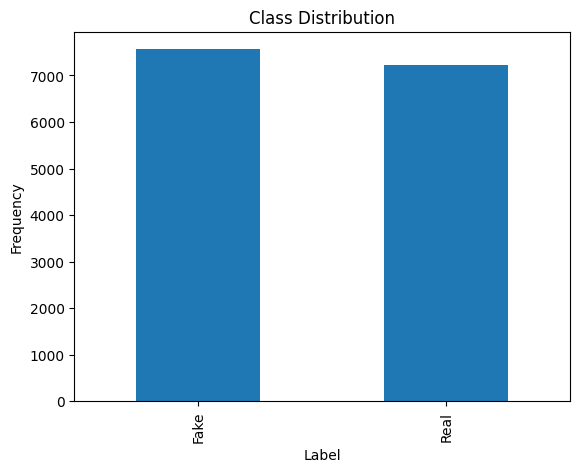

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

class_distribution = df['label'].value_counts()
print("Class Distribution:", class_distribution)

# Plot class distribution
class_distribution.plot(kind='bar', title='Class Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency') 
plt.xticks(ticks=[0, 1], labels=['Fake', 'Real'])
plt.show()

2. **Frequent Words**

    - To visualise the most frequent words, word clouds for fake and real news articles are plotted.

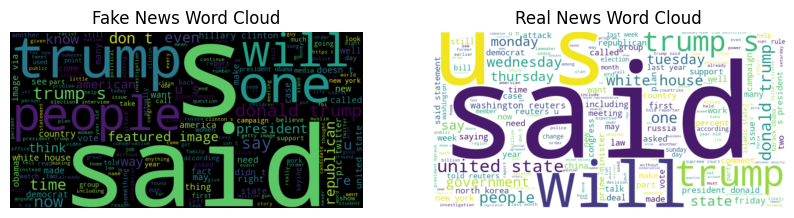

In [17]:
# Generate word clouds for fake and real articles
fake_articles = df[df['label'] == 0]['preprocessed_text'].str.cat(sep=' ')
real_articles = df[df['label'] == 1]['preprocessed_text'].str.cat(sep=' ')

wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_articles)
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_articles)

# Plot the word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Fake News Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Real News Word Cloud')
plt.axis('off')

plt.show()

3. **Subject Distribution**

    - The code creates and displays a bar chart showing the distribution of different subjects in the dataset.

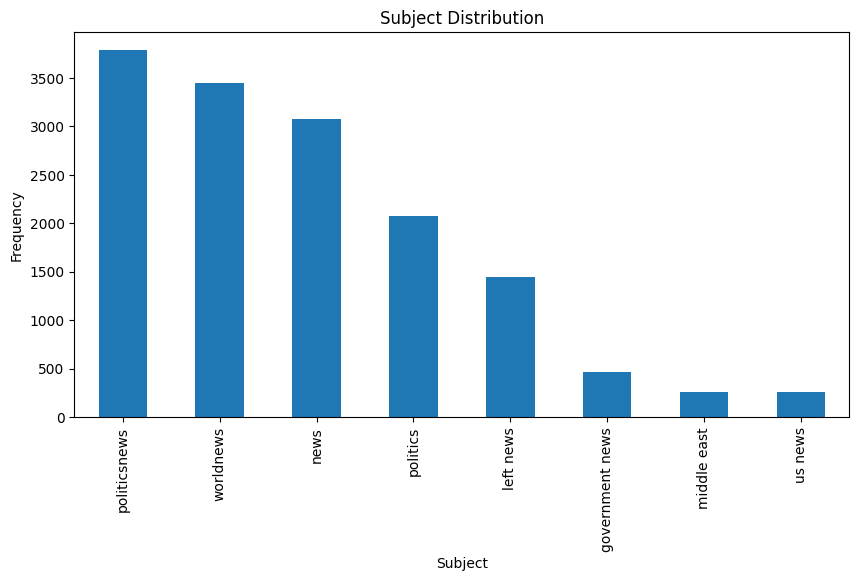

In [18]:
df['preprocessed_subject'].value_counts().plot(kind='bar', figsize=(10, 5), title='Subject Distribution')
plt.xlabel('Subject')
plt.ylabel('Frequency')
plt.show()

4. **Article Length Distribution**

    - The code generates and displays a histogram showing the distribution of article lengths in the dataset. This visualisation helps in understanding the typical length of articles in the dataset, indicating that most articles are relatively short.

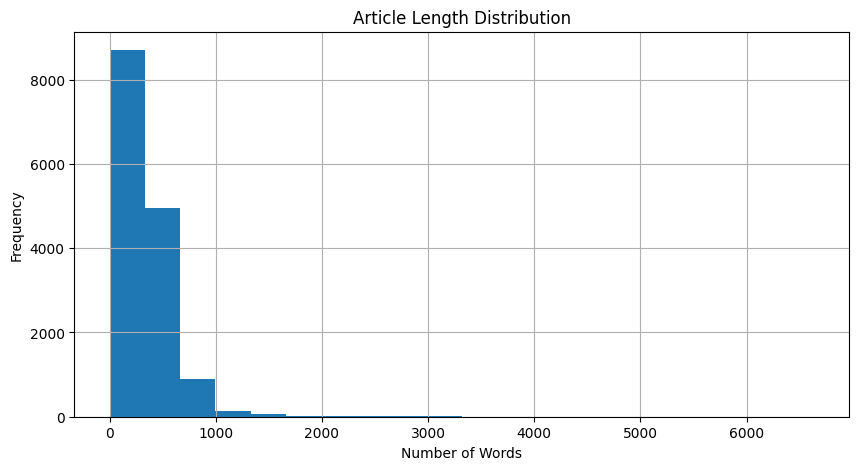

In [19]:
df['article_length'] = df['preprocessed_text'].apply(lambda x: len(x.split()))
df['article_length'].hist(bins=20, figsize=(10, 5))

plt.title('Article Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

5. **Sentiment Distribution**

    - The distribution of sentiment polarity scores for fake and real news articles was visualised using a histogram. This visualisation helped in understanding the sentiment characteristics of fake and real news articles, indicating that while both tend to cluster around neutral sentiment, fake news articles show a wider range of sentiment polarity. 

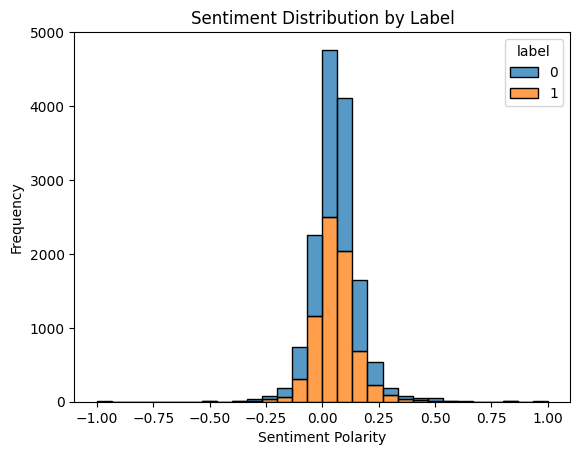

In [20]:
# Sentiment analysis for fake and real articles
df['sentiment'] = df['preprocessed_text'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Plot sentiment distribution by label
sns.histplot(data=df, x='sentiment', hue='label', multiple='stack', bins=30)
plt.title('Sentiment Distribution by Label')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

## Model Initialisation
The following two models were selected for training and evaluation:

1. **Random Forest Classifier**
    - The Random Forest Classifier was initialised with 100 estimators and a random state for reproducibility. This model was chosen due to its robustness against overfitting and its ability to handle large datasets effectively. Its ensemble nature, combining multiple decision trees, enhances predictive accuracy and generalisation.

2. **Support Vector Machine (SVM)**
    - The SVM model was initialised with a linear kernel and included in a pipeline with `StandardScaler` to normalize the data. The SVM model was chosen for its effectiveness in high-dimensional spaces and its versatility across various classification tasks. The linear kernel was selected for its simplicity and efficiency, making it suitable for text classification.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Create the models
models = {
    "Random Forest Model": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine Model": make_pipeline(StandardScaler(with_mean=False), SVC(kernel='linear', C=1))
}

## Model Training and Evaluation

Each model is trained and evaluated. The `train_and_evaluate` function takes a machine learning model and its name as inputs and performs the following steps:

1. **Training the Model** 
   - The function trains the provided model on the training dataset (`x_train` and `y_train`).
   
2. **Validation Evaluation**
   - After training, the model makes predictions on the validation set (`x_val`).
   - These predictions are then compared to the true labels (`y_val`) to evaluate the model's performance during the training phase.
   - The validation accuracy and a detailed classification report (which includes precision, recall, and F1-score for each class) are printed.

3. **Test Evaluation**
   - The function then makes predictions on the test set (`x_test`).
   - These predictions are compared to the true labels (`y_test`) to evaluate the model's performance on unseen data.
   - The test accuracy and a detailed classification report are printed for further insights into the model's performance.

4. **Learning Curve Plotting**
   - A learning curve is plotted using the `plot_learning_curve` function to visualize the model's performance over varying sizes of training data. This helps in understanding how the model's performance evolves with more data, providing insights into pontential overfitting or underfitting.

5. **Model Saving**
   - Finally, the trained model is saved to a file using `joblib` for future use to mak epredictions without retraining.

Training and Evaluating Random Forest Model...
Random Forest Model Validation Accuracy: 0.9953547297297297
Random Forest Model Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1180
           1       1.00      0.99      1.00      1188

    accuracy                           1.00      2368
   macro avg       1.00      1.00      1.00      2368
weighted avg       1.00      1.00      1.00      2368

Random Forest Model Test Accuracy: 0.995945945945946
Random Forest Model Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1495
           1       1.00      1.00      1.00      1465

    accuracy                           1.00      2960
   macro avg       1.00      1.00      1.00      2960
weighted avg       1.00      1.00      1.00      2960



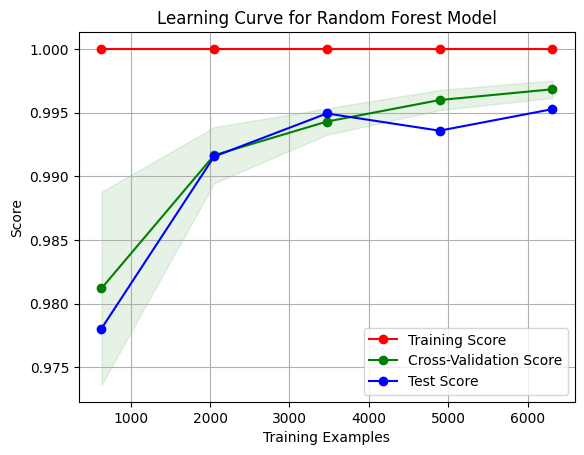

Training and Evaluating Support Vector Machine Model...
Support Vector Machine Model Validation Accuracy: 0.9911317567567568
Support Vector Machine Model Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1180
           1       0.99      0.99      0.99      1188

    accuracy                           0.99      2368
   macro avg       0.99      0.99      0.99      2368
weighted avg       0.99      0.99      0.99      2368

Support Vector Machine Model Test Accuracy: 0.9902027027027027
Support Vector Machine Model Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1495
           1       0.99      0.99      0.99      1465

    accuracy                           0.99      2960
   macro avg       0.99      0.99      0.99      2960
weighted avg       0.99      0.99      0.99      2960



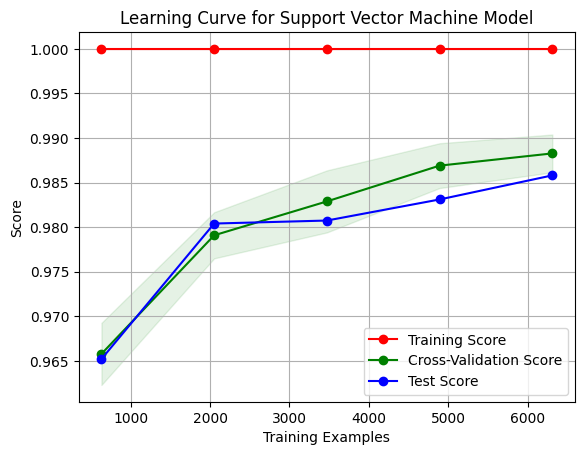

In [31]:
import numpy as np
from sklearn.model_selection import learning_curve
import joblib
from sklearn.metrics import accuracy_score, classification_report

def plot_learning_curve(estimator, title, x_train, y_train, x_test, y_test, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    
    # Reduce the number of training sizes
    train_sizes = np.linspace(0.1, 1.0, 5)
    
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, x_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Compute test scores for each training size
    test_scores = []
    for train_size in train_sizes:
        estimator.fit(x_train[:train_size], y_train[:train_size])
        test_score = estimator.score(x_test, y_test)
        test_scores.append(test_score)
    test_scores = np.array(test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training Score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g",
             label="Cross-Validation Score")
    plt.plot(train_sizes, test_scores, 'o-', color="b",
             label="Test Score")

    plt.legend(loc="best")
    plt.savefig(f'{title}.png')
    plt.show()

def train_and_evaluate(model, model_name):
    # Train the model
    model.fit(x_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(x_val)
    print(f"{model_name} Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    print(f"{model_name} Validation Classification Report:\n", classification_report(y_val, y_val_pred))

    # Evaluate on test set
    y_test_pred = model.predict(x_test)
    print(f"{model_name} Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print(f"{model_name} Test Classification Report:\n", classification_report(y_test, y_test_pred))

    # Plot learning curve
    plot_learning_curve(estimator=model, title=f"Learning Curve for {model_name}", x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, cv=3, n_jobs=-1)

    # Save the model
    joblib.dump(model, f'{model_name}.joblib')

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training and Evaluating {model_name}...")
    train_and_evaluate(model, model_name)

## Vectorizer and Encoder Saving

The TF-IDF vectorizers used for transforming the text data (title, text, subject) and the OneHotEncoder used to encode the sentiment values are saved using `joblib` to ensure consistent transformations of new data.

In [32]:
joblib.dump(vectorizer_text, 'vectorizer_text.joblib')
joblib.dump(vectorizer_title, 'vectorizer_title.joblib')
joblib.dump(vectorizer_subject, 'vectorizer_subject.joblib')
joblib.dump(encoder, 'encoder_sentiment.joblib')

['encoder_sentiment.joblib']